In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%cd ..

/Users/rubenbroekx/Documents/Projects/radix-co2-reduction


# Align Satellite Readings

Align the values obtained by the satellite imagery (Landsat7-SR, Landsat8-SR, and Sentinel2) by evaluating each satellite's overall values and comparing different satellites for readings on the same day. 

In [29]:
import ee
import json
import matplotlib.pyplot as plt

from collections import Counter
from glob import glob
from pathlib import Path
from tqdm import tqdm
from datetime import datetime, timedelta

from src.radix_co2_reduction.earth_engine.session import start
from src.radix_co2_reduction.earth_engine.utils import create_polygon
from src.radix_co2_reduction.earth_engine.datasets import Landsat7Collection,Landsat8Collection,Sentinel2Collection

In [4]:
# Root data folder
DATA = Path.home() / 'data/agoro/2021-05-01'

In [5]:
# Fetch field-IDs
all_ids = glob(str(DATA / '*/ndti.png'))
all_ids = [int(i.split('/')[-2]) for i in all_ids]

In [6]:
# All the bands
BANDS = ['B','G','R','NIR','SWIR1','SWIR2']

In [7]:
# Start the Earth Engine session
start()

Enter verification code: 4/1AY0e-g5YH5aB9FUesDpqbFMxruq3qN3xHvbrfidf55T9Fh8ALRmb4lYGPEU

Successfully saved authorization token.


## Overall values

Evaluate each satellite's overall values. Main take away is that it's safe to assume that all values (for all satellites, over all the bands) lie within 0 and 5000.

In [8]:
def plot_overall_values(tag:str)->None:
    data = {b:[] for b in BANDS}
    for i in all_ids:
        with open(DATA / f"{i}/samples/{tag}.json", 'r') as f:
            field = json.load(f)
        for b in BANDS:
            data[b] += [round(x) for values in field.values() for x in values[b] if x is not None]
    
    plt.figure(figsize=(20,8))
    plt.suptitle(tag)
    for i, b in enumerate(tqdm(BANDS, desc='Visualising')):
        plt.subplot(2,3,i+1)
        plt.title(b)
        c = Counter(data[b])
        k,v = zip(*sorted(c.items()))
        plt.bar(k,v)
    plt.show()

Visualising: 100%|██████████| 6/6 [00:10<00:00,  1.76s/it]


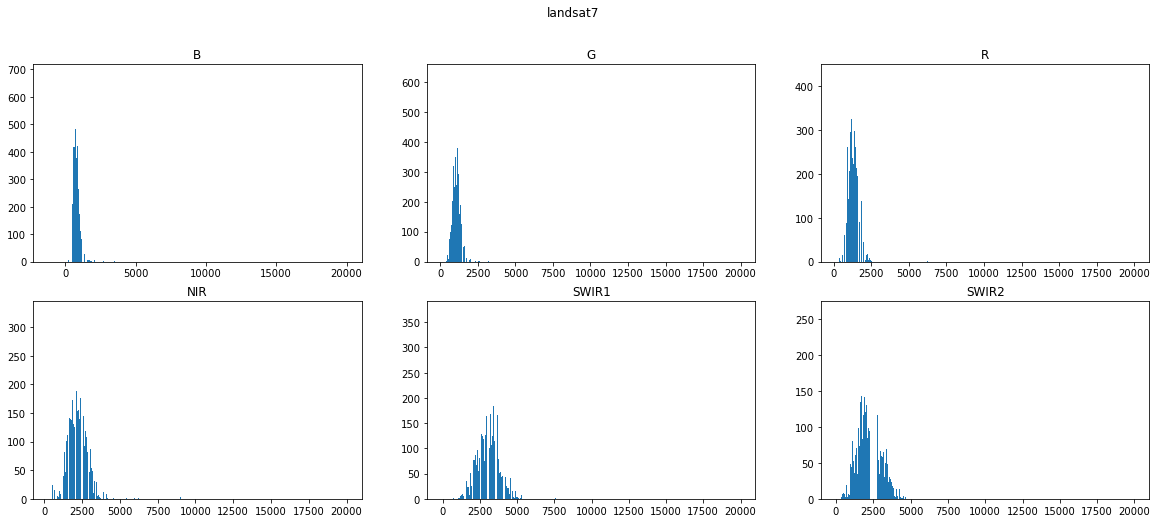

In [9]:
plot_overall_values('landsat7')

Visualising: 100%|██████████| 6/6 [00:13<00:00,  2.28s/it]


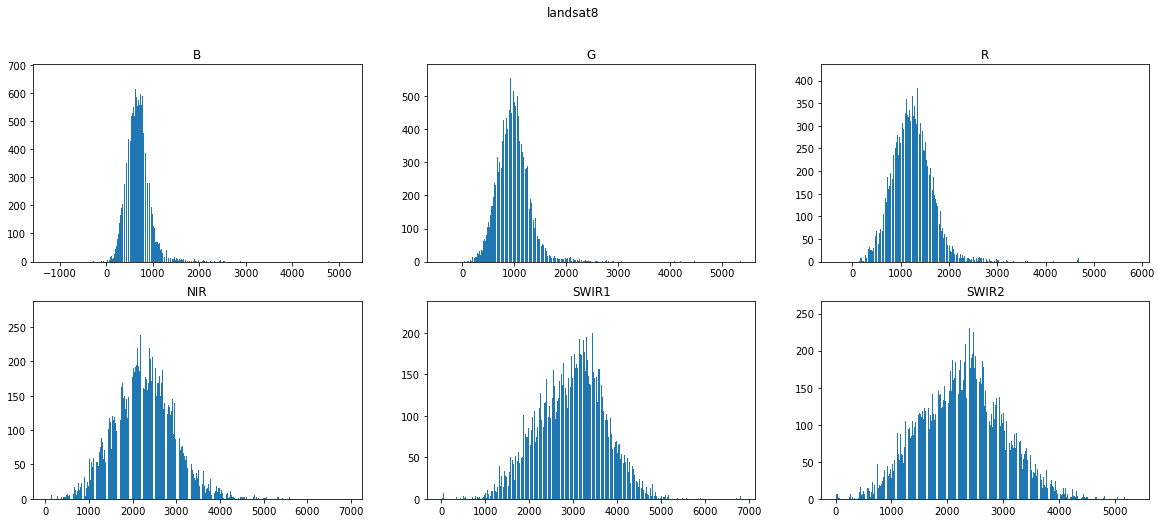

In [10]:
plot_overall_values('landsat8')

Visualising: 100%|██████████| 6/6 [00:13<00:00,  2.29s/it]


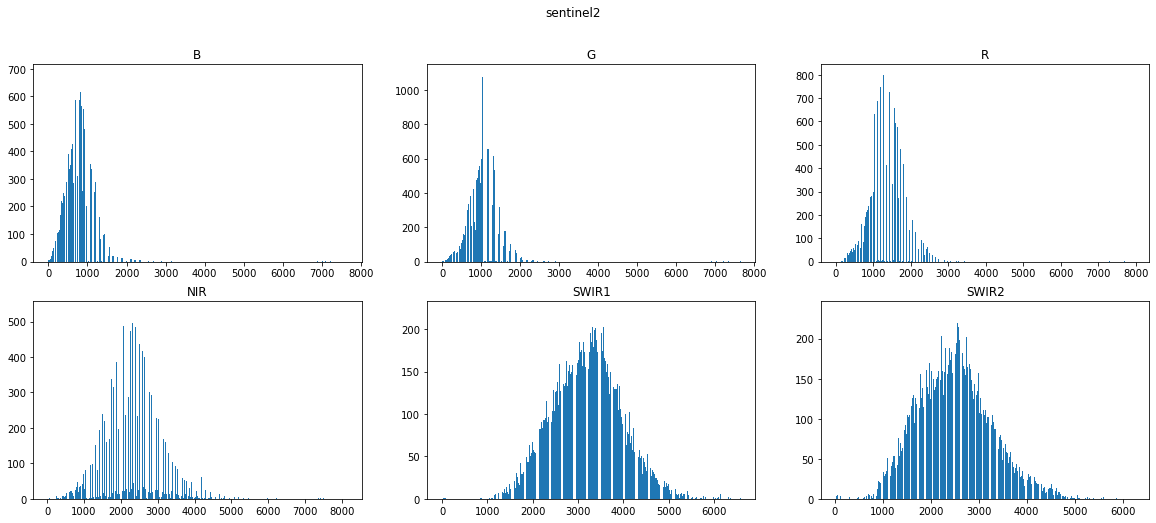

In [11]:
plot_overall_values('sentinel2')

# Align Cross Satellite

Try to align the three satellites (Landsat7, Landsat8, and Sentinel2) as good as possible. This is done by comparing their values on the same day. Note, Landsat7 and Landsat8 are never on the same place at the same time (this is by design, I think).

In [12]:
def get_partial_match(i):
    """Return all matches (same field, same day) between two different satellites."""
    with open(DATA / f'{i}/samples/landsat7.json', 'r') as f:
        ls7 = json.load(f)
    with open(DATA / f'{i}/samples/landsat8.json', 'r') as f:
        ls8 = json.load(f)
    with open(DATA / f'{i}/samples/sentinel2.json', 'r') as f:
        s2 = json.load(f)
    
    all_keys = ls7.keys() | ls8.keys() | s2.keys()
    matches = []
    for k in all_keys:
        if k in ls7.keys() and k in ls8.keys():
            matches.append(('ls7-ls8', i, k))
        if k in ls7.keys() and k in s2.keys():
            matches.append(('ls7-s2', i, k))
        if k in ls8.keys() and k in s2.keys():
            matches.append(('ls8-s2', i, k))
    return matches

matches = []
for i in tqdm(all_ids):
    matches += get_partial_match(i)
    
Counter([x for x,_,_ in matches])

100%|██████████| 628/628 [00:02<00:00, 254.75it/s]


Counter({'ls8-s2': 279, 'ls7-s2': 209})

In [13]:
# Load in all field-boundaries
with open(Path.cwd() / 'data/polygons.json', 'r') as f:
    boundaries = json.load(f)

In [59]:
def tomorrow(date):
    return (datetime.strptime(date, '%Y-%m-%d') + timedelta(days=1)).strftime('%Y-%m-%d')

In [152]:
def sample(tag,i,date,n=100):
    """Sample the given field over the requested collections."""
    field_boundary = create_polygon([boundaries[str(i)]])
    
    # Get pixel to sample over
    pixels = ee.FeatureCollection.randomPoints(  # type: ignore
            region=field_boundary,
            points=n,
            seed=42,
            maxError=50,
    )
    
    # Load in the datasets
    ls7 = Landsat7Collection()
    ls8 = Landsat8Collection()
    s2 = Sentinel2Collection()
    if tag == 'ls7-ls8':
        a,b = ls7,ls8
    elif tag == 'ls7-s2':
        a,b = ls7,s2
    elif tag == 'ls8-s2':
        a,b = ls8,s2
    else:
        raise Exception("Invalid tag")
    a.load_collection(
            region=field_boundary,
            startdate=date,
            enddate=tomorrow(date),
            filter_clouds=False,
            return_masked=False,
    )
    a_size = a.get_size()
    if a_size != 1:
        print(f"{a} has not the good size ({a_size})")
        return
    b.load_collection(
            region=field_boundary,
            startdate=date,
            enddate=tomorrow(date),
            filter_clouds=False,
            return_masked=False,
    )
    b_size = b.get_size()
    if b_size != 1:
        print(f"{b} has not the good size ({b_size})")
        return
    
    # Sample
    def _sample(im):
        """Sample over the given image."""
        return im.sample(
                region=pixels,
                dropNulls=False,
                scale=1,
                seed=42,
        )
    a_s = _sample(a.collection.first()).getInfo()['features']
    b_s = _sample(b.collection.first()).getInfo()['features']
    samples = {b:[] for b in BANDS}
    for i in range(min(n, len(a_s), len(b_s))):
        if a_s[i]['properties']['B2'] is None or b_s[i]['properties']['B2'] is None: continue
        for band in BANDS:
            samples[band].append((
                a_s[i]['properties'][a.band_translation[band]],
                b_s[i]['properties'][b.band_translation[band]],
            ))
    return samples

# Fetch all alignments
N = 50  # Only use first 50
results = {
    'ls7-ls8': {b:[] for b in BANDS},
    'ls7-s2': {b:[] for b in BANDS},
    'ls8-s2': {b:[] for b in BANDS},
}
seen = {
    'ls7-ls8':0,
    'ls7-s2':0,
    'ls8-s2':0,
}
for tag,field_id,date in tqdm(matches):
    if seen[tag] >= N: continue
    result = sample(tag, field_id, date)
    for b in BANDS:
        results[tag][b] += result[b]
    seen[tag] += 1

100%|██████████| 488/488 [10:25<00:00,  1.28s/it] 


In [166]:
# Plot the results and predict a linear model onto it
def scatter_alignment(tag):
    plt.figure(figsize=(20,10))
    plt.suptitle(tag)
    
    models = {}
    for i, b in enumerate(tqdm(BANDS, desc='Visualising')):
        plt.subplot(2,3,i+1)
        plt.title(b)
        plt.grid()
        x,y = zip(*[(a,b) for a,b in results[tag][b] if (b/2 <= a <= 2*b) or (a/2 <= b <= 2*a)])
        max_v = max(max(x),max(y))
        plt.scatter(x,y)
        plt.xlim(0,max_v)
        plt.ylim(0,max_v)
        
        # Create linear regression model as well
        s = sorted(x)
        x,y = np.asarray(x)[:,None],np.asarray(y)[:,None]
        regr = LinearRegression()
        regr.fit(x,y)
        pred = regr.predict(x)
        plt.plot(x,pred,color='red')
        models[b] = regr
    plt.show()
    return models

Visualising: 100%|██████████| 6/6 [00:00<00:00, 14.02it/s]


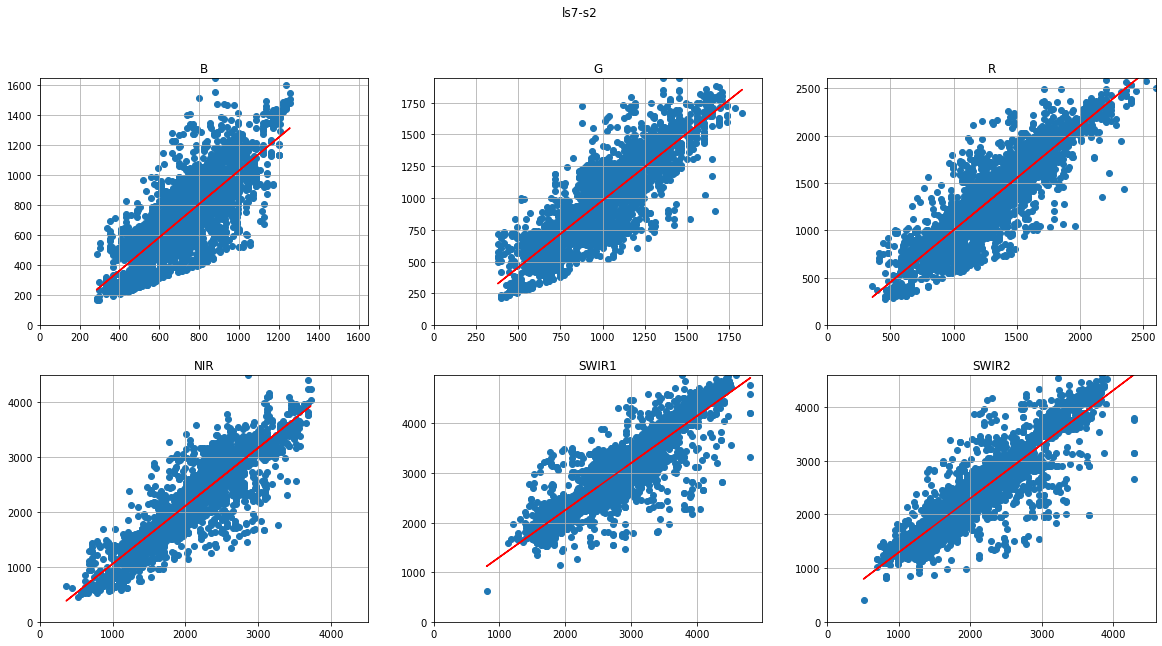

In [167]:
models_ls7_s2 = scatter_alignment('ls7-s2')

Visualising: 100%|██████████| 6/6 [00:00<00:00, 20.15it/s]


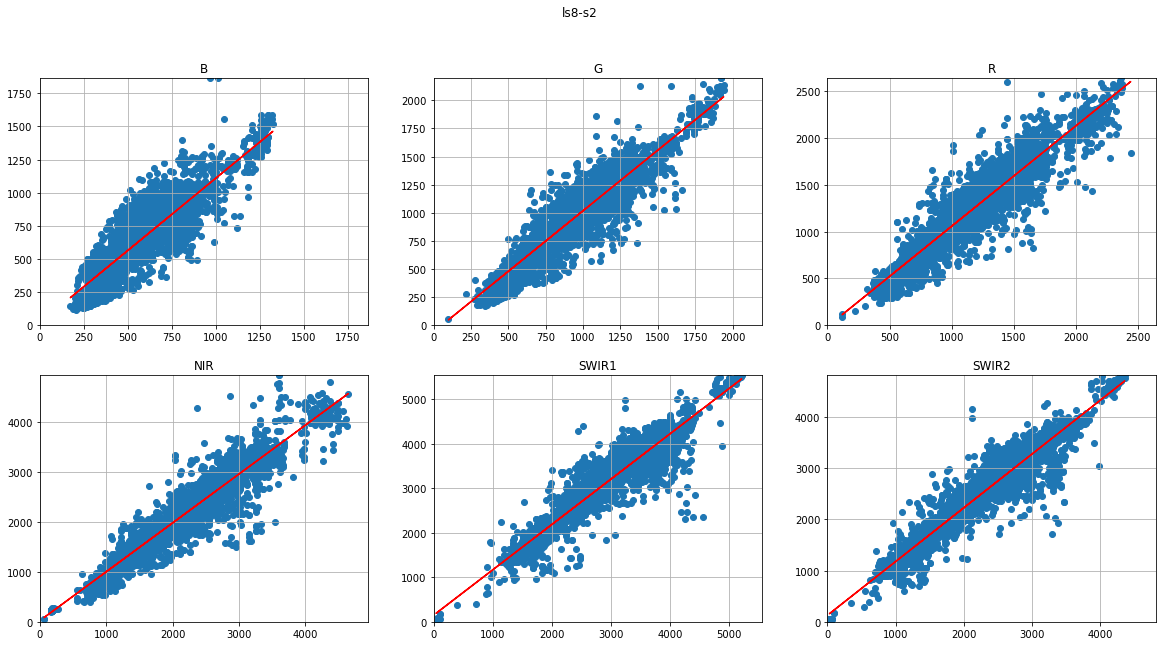

In [168]:
models_ls8_s2 = scatter_alignment('ls8-s2')

In [156]:
# Plot the linear equations
def model_to_function(model) -> str:
    pred = model.predict([[0],[1]])
    return f"y = {pred[1][0]-pred[0][0]} * x + {pred[0][0]}"

print("For LS7 - S2")
for b in BANDS:
    print(f" - Band {b} has function: {model_to_function(models_ls7_s2[b])}")
print("\nFor LS8 - S2")
for b in BANDS:
    print(f" - Band {b} has function: {model_to_function(models_ls8_s2[b])}")

For LS7 - S2
 - Band B has function: y = 1.112811847474049 * x + -94.70397321936775
 - Band G has function: y = 0.9962443147174973 * x + -16.60254538456445
 - Band R has function: y = 1.0178517179471047 * x + 14.319301242381016
 - Band NIR has function: y = 0.9642095752159605 * x + 197.1975041308283
 - Band SWIR1 has function: y = 0.8796297842112608 * x + 555.3260817293158
 - Band SWIR2 has function: y = 0.9528231611557771 * x + 412.1632817588654

For LS8 - S2
 - Band B has function: y = 1.0884327621943228 * x + 19.22407971615371
 - Band G has function: y = 1.0837195311885495 * x + -68.41594723747096
 - Band R has function: y = 1.0677278435847697 * x + -7.207318548633111
 - Band NIR has function: y = 0.9753691863053184 * x + 23.108379232653533
 - Band SWIR1 has function: y = 1.0178813893209906 * x + 142.71785656044312
 - Band SWIR2 has function: y = 1.039069455146489 * x + 138.69849745406736


In [190]:
# Plot the results and predict a linear model onto it
def scatter_after_alignment(tag, models):
    plt.figure(figsize=(20,10))
    plt.suptitle(f"{tag}: aligned")
    
    for i, b in enumerate(tqdm(BANDS, desc='Visualising')):
        plt.subplot(2,3,i+1)
        plt.title(b)
        plt.grid()
        x,y = zip(*[(a,b) for a,b in results[tag][b] if (b/2 <= a <= 2*b) or (a/2 <= b <= 2*a)])
        xx = models[b].predict([[a] for a in x])
        max_v = max(max(x),max(y))
        plt.scatter(xx,y)
        plt.xlim(0,max_v)
        plt.ylim(0,max_v)
        plt.plot(x,x,color='red')  # Plot diagonal
    plt.show()

Visualising: 100%|██████████| 6/6 [00:00<00:00, 32.81it/s]


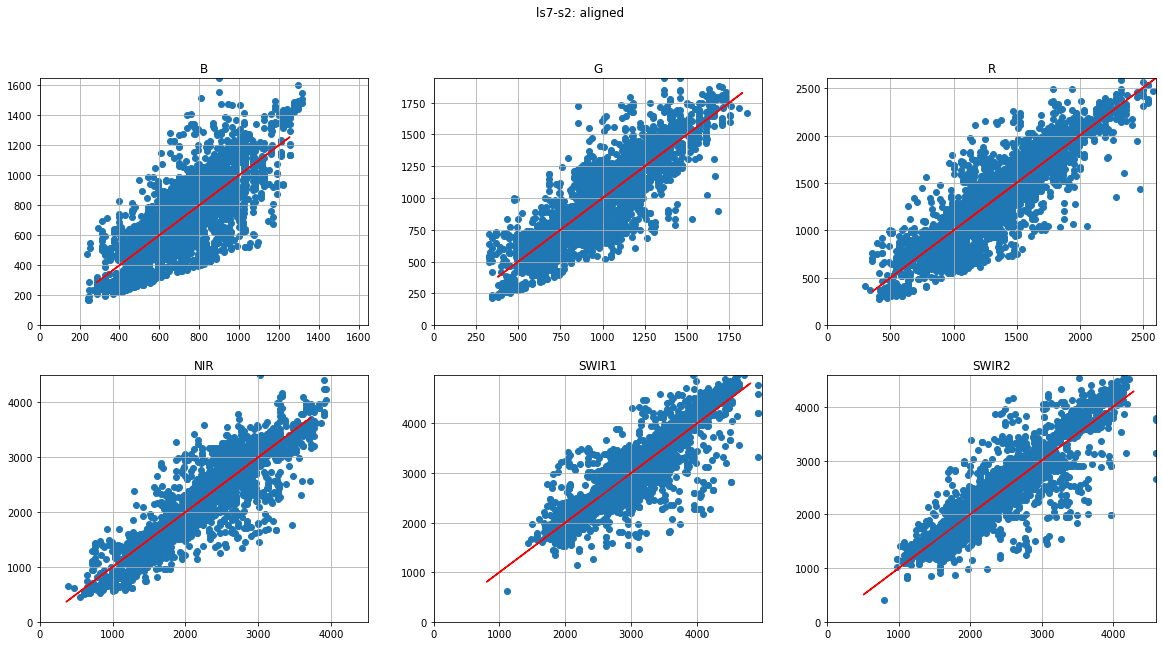

In [191]:
scatter_after_alignment('ls7-s2', models_ls7_s2)

Visualising: 100%|██████████| 6/6 [00:00<00:00, 30.20it/s]


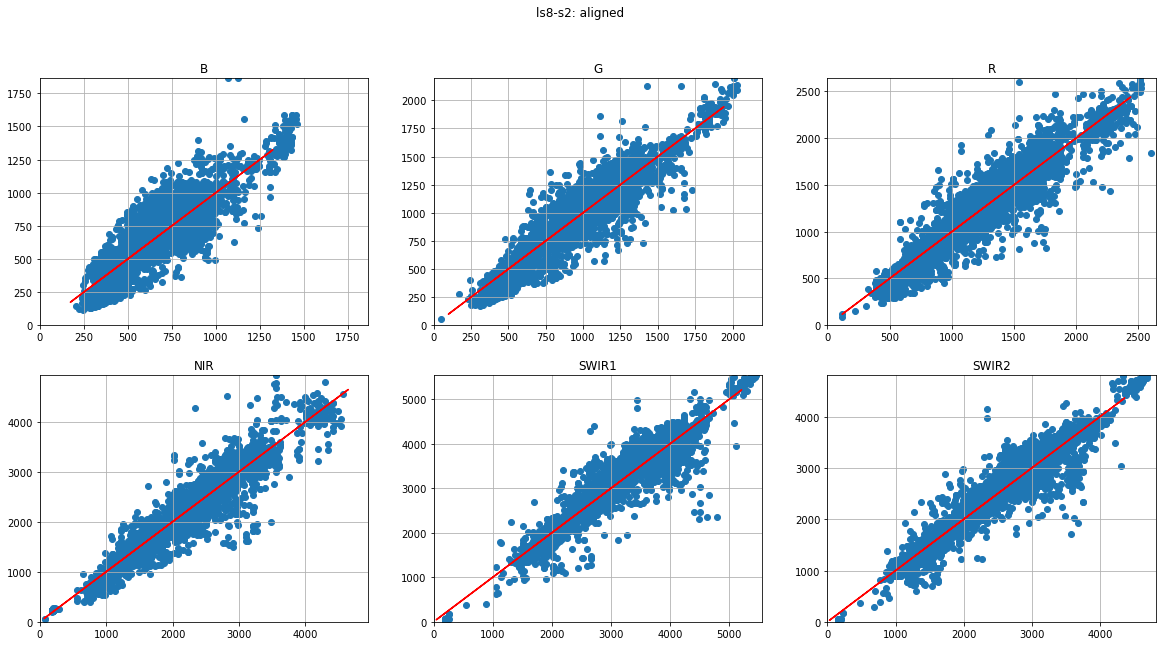

In [192]:
scatter_after_alignment('ls8-s2', models_ls8_s2)